# 3.b Model Development (Open)

In [1]:
import numpy as np
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import boto3 
import io  
from sagemaker import get_execution_role
role = get_execution_role()
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
role

'arn:aws:iam::190183093544:role/service-role/AmazonSageMaker-ExecutionRole-20220602T141236'

In [3]:
session = boto3.Session()

### Load the Data from S3

In [4]:
bucket='data-aman-use-case'  
file_key = 'x_train_open.npy' 
  
s3_client = boto3.client('s3')  
obj = s3_client.get_object(Bucket=bucket, Key=file_key)  
x_train_open = np.load(io.BytesIO(obj['Body'].read()))  

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [5]:
bucket='data-aman-use-case'  
file_key = 'x_test_open.npy' 
  
s3_client = boto3.client('s3')  
obj = s3_client.get_object(Bucket=bucket, Key=file_key)  
x_test_open = np.load(io.BytesIO(obj['Body'].read()))  

In [6]:
bucket='data-aman-use-case'  
file_key = 'y_train_open.npy' 
  
s3_client = boto3.client('s3')  
obj = s3_client.get_object(Bucket=bucket, Key=file_key)  
y_train_open = np.load(io.BytesIO(obj['Body'].read()))  

In [7]:
bucket='data-aman-use-case'  
file_key = 'y_test_open.npy' 
  
s3_client = boto3.client('s3')  
obj = s3_client.get_object(Bucket=bucket, Key=file_key)  
y_test_open = np.load(io.BytesIO(obj['Body'].read()))  

### Building the LSTM RNN Model

In [8]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train_open.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 25)                2525      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train_open, y_train_open, batch_size= 1, epochs=12)

Epoch 1/12
2216/2216 [==============================] - 68s 31ms/step - loss: 2.1025e-04
Epoch 2/12
2216/2216 [==============================] - 69s 31ms/step - loss: 8.6258e-05
Epoch 3/12
2216/2216 [==============================] - 67s 30ms/step - loss: 8.1022e-05
Epoch 4/12
2216/2216 [==============================] - 68s 31ms/step - loss: 6.4587e-05
Epoch 5/12
2216/2216 [==============================] - 66s 30ms/step - loss: 6.0659e-05
Epoch 6/12
2216/2216 [==============================] - 65s 30ms/step - loss: 4.9606e-05
Epoch 7/12
2216/2216 [==============================] - 71s 32ms/step - loss: 4.8595e-05
Epoch 8/12
2216/2216 [==============================] - 70s 32ms/step - loss: 4.5203e-05
Epoch 9/12
2216/2216 [==============================] - 66s 30ms/step - loss: 4.4573e-05
Epoch 10/12
2216/2216 [==============================] - 70s 32ms/step - loss: 4.4526e-05
Epoch 11/12
2216/2216 [==============================] - 70s 32ms/step - loss: 4.4603e-05
Epoch 12/12
2216/22

### Scaling values in local env

In [16]:
btc = f'https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1410912000&period2=1656633600&interval=1d&events=history&includeAdjustedClose=true'

In [17]:
data= pd.read_csv(btc, parse_dates=['Date'], index_col=['Date'])

In [19]:
open_prices = data['Open']
values_open = open_prices.values
training_data_len_open = math.ceil(len(values_open)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_open = scaler.fit_transform(values_open.reshape(-1, 1))
train_data_open = scaled_data_open[0: training_data_len_open, :]

x_train_open = []
y_train_open = []

for i in range(60, len(train_data_open)):
    x_train_open.append(train_data_open[i-60:i, 0])
    y_train_open.append(train_data_open[i, 0])
x_train_open, y_train_open = np.array(x_train_open), np.array(y_train_open)
x_train_open = np.reshape(x_train_open, (x_train_open.shape[0], x_train_open.shape[1], 1))

In [20]:
test_data_open= scaled_data_open[training_data_len_open-60: , : ]
x_test_open = []
y_test_open = values_open[training_data_len_open:]

for i in range(60, len(test_data_open)):
    x_test_open.append(test_data_open[i-60:i, 0])

x_test_open = np.array(x_test_open)
x_test_open = np.reshape(x_test_open, (x_test_open.shape[0], x_test_open.shape[1], 1))

### Making predictions and looking at the RMSE

In [21]:
predictions = model.predict(x_test_open)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test_open)**2)
rmse

3010.8376058539097

### Visualizing model performance

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


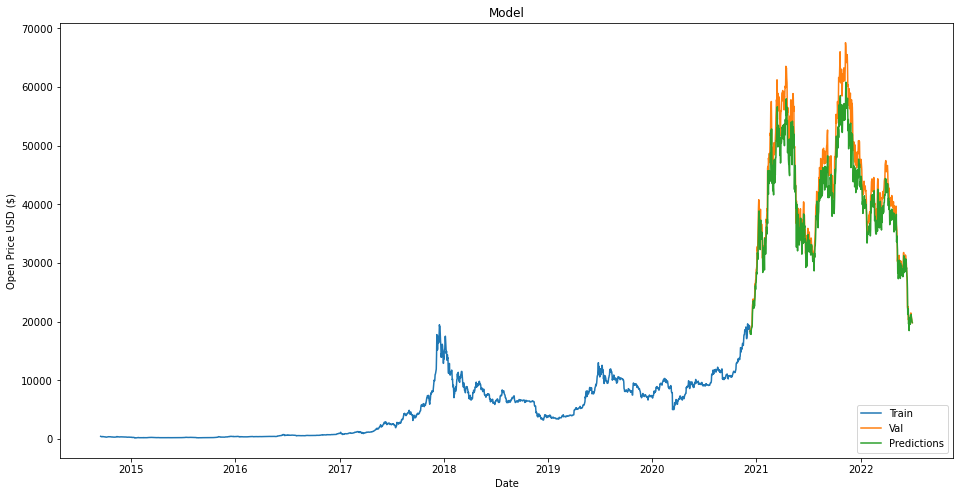

In [22]:
data = data.filter(['Open'])
train = data[:training_data_len_open]
validation = data[training_data_len_open:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Open Price USD ($)')
plt.plot(train)
plt.plot(validation[['Open', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()